-----------------------------------
# 
# **[HW 5](https://github.com/lucamaiano/ADM/tree/master/2022/Homework_5)** - The Marvel Universe!
-----------------------------------
###### **Laura Mignella** : 1920520
###### **Luca Mazzucco** : 1997610
###### **Sharifeh Alaei** : 2050840
-----------------------------------
##### Download the **data** from [**Kaggle**](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network?select=hero-network.csv).
-----------------------------------

# 1. Data

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
from collections import Counter

from zipfile import ZipFile
from io import BytesIO
import requests

I read the datasets I'm going to work on and I save them in the dataframes:
hero_net, edges, nodes.

In [2]:
hero_net=pd.read_csv('hero-network.csv')
edges=pd.read_csv('edges.csv')
nodes=pd.read_csv('nodes.csv')

Let's take a look at the dataframes

In [3]:
hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE /
574464,CALLISTO,CALIBAN/
574465,CALIBAN/,ROGUE /


In [4]:
edges

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [5]:
nodes

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


# Data

## Data Preprocessing

I remove the extra spaces and the extra '/' at the end of the heroes names in hero_net.

I replace the name "SPIDER-MAN/PETER PAR" with the name "SPIDER-MAN/PETER PARKER" throughout the dataframe hero_net.

In [6]:
hero_net['hero1']=hero_net['hero1'].apply(lambda x : x.rstrip("/").rstrip(" "))
hero_net['hero2']=hero_net['hero2'].apply(lambda x : x.rstrip("/").rstrip(" "))
edges['hero']=edges['hero'].apply(lambda x : x.rstrip("/").rstrip(" "))
nodes['node']=nodes['node'].apply(lambda x : x.rstrip("/").rstrip(" "))

hero_net.hero1.loc[hero_net['hero1'] == "SPIDER-MAN/PETER PAR"] = "SPIDER-MAN/PETER PARKER"
hero_net.hero2.loc[hero_net['hero2'] == "SPIDER-MAN/PETER PAR"] = "SPIDER-MAN/PETER PARKER"

I remove the rows in hero_net that have the same hero in both columns.

In [7]:
hero_net.drop(hero_net[hero_net['hero1'] == hero_net['hero2']].index, inplace=True)

I noticed that in the nodes.csv dataset "SPIDER-MAN/PETER PARKER" appears once with the name "SPIDER-MAN/PETER PARKERKER". I replace the name "SPIDER-MAN/PETER PARKERKER" with the name "SPIDER-MAN/PETER PARKER".

Moreover I noticed that in the column 'comic' of the edges.csv dataset, the comic "CURRY/MAJOR MERCURY/" appears. It does not appear in the nodes.csv dataset so I dropped the row.

In [8]:
nodes.node.loc[nodes['node'] == "SPIDER-MAN/PETER PARKERKER"] = "SPIDER-MAN/PETER PARKER"
edges = edges[edges.comic != "CURRY/MAJOR MERCURY/"]

## Graphs setup

### First Graph

In the first graph an edge between two heroes can be found if they have appeared in the same comic together.

To obtain the edges of the graph, for each row I create a sorted tuple (sorted in alphabetical order) containing (hero1,hero2). I group the tuples and count the number of times each tuple appears in the dataframe. This is the number of partnerships between the two heroes.

In [9]:
hero_net['tuple']=hero_net.apply(lambda row: (row['hero1'], row['hero2']), axis=1)

In [10]:
hero_net['tuple']=hero_net['tuple'].apply(lambda x: tuple(sorted(x)))

I add in the new 'colab' column of the dataframe the number of collaborations between the two heros in each tuple and I create the 'weight' column. It contains 1/number of collaborations between the two heroes in each tuple.

In [11]:
hero_net=hero_net.groupby(['tuple']).size().reset_index().rename(columns={0: 'colab'})

In [12]:
hero_net['weight']=1/hero_net['colab']

In [13]:
# I re-add the hero1 and hero2 columns to the dataframe
hero_net['hero1']=hero_net['tuple'].apply(lambda x: x[0])
hero_net['hero2']=hero_net['tuple'].apply(lambda x: x[1])

In [14]:
hero_net

,tuple,colab,weight,hero1,hero2
0,"(24-HOUR MAN/EMMANUEL, FROST, CARMILLA)",1,1.00,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA"
1,"(24-HOUR MAN/EMMANUEL, G'RATH)",1,1.00,24-HOUR MAN/EMMANUEL,G'RATH
2,"(24-HOUR MAN/EMMANUEL, KILLRAVEN/JONATHAN R)",1,1.00,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R
3,"(24-HOUR MAN/EMMANUEL, M'SHULLA)",1,1.00,24-HOUR MAN/EMMANUEL,M'SHULLA
4,"(24-HOUR MAN/EMMANUEL, OLD SKULL)",1,1.00,24-HOUR MAN/EMMANUEL,OLD SKULL
...,...,...,...,...,...
167095,"(ZEFRA, ZON)",1,1.00,ZEFRA,ZON
167096,"(ZEUS, ZIRAN)",1,1.00,ZEUS,ZIRAN
167097,"(ZEUS, ZURAS)",4,0.25,ZEUS,ZURAS
167098,"(ZIRAN, ZON)",1,1.00,ZIRAN,ZON


I create a graph, not a multigraph. I add the 'weight' column and the 'colab' column as attributes of the edges.

In [15]:
# I create the graph
G_hero_net1=nx.from_pandas_edgelist(hero_net, 'hero1', 'hero2', edge_attr=['weight', 'colab'], create_using=nx.Graph())

In [16]:
nx.info(G_hero_net1)

C:\Users\laura\AppData\Local\Temp\ipykernel_30148\4049710215.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G_hero_net1)


'Graph with 6421 nodes and 167100 edges'

### Second Graph

In the second graph an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. The type of node (hero/comic) can be found in 'nodes.csv'.

In [17]:
G_hero_net2=nx.Graph()

In [18]:
# For each node I add the attribute hero or comic
G_hero_net2.add_nodes_from([x, {"type": y}] for x,y in zip(nodes.node, nodes.type))

In [19]:
# I create the edges and add them to the graph
edges.apply(lambda row: G_hero_net2.add_edge(row['hero'], row['comic']), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
96099    None
96100    None
96101    None
96102    None
96103    None
Length: 96103, dtype: object

In [20]:
nx.info(G_hero_net2)

C:\Users\laura\AppData\Local\Temp\ipykernel_30148\3077743940.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G_hero_net2)


'Graph with 19087 nodes and 96103 edges'

# Backend Implementation

## Top N heroes

To build the subgraphs to work on, I create an ordered list that contains the heroes. The first item in the list is the hero who appears in the most comics, the last item in the list is the hero who appears in the fewest comics.

In [21]:
top_heros = edges.groupby(['hero']).count()
top_heros = top_heros.sort_values('comic', ascending=False)

In [22]:
n_heros=list(top_heros.index)

In [23]:
# Here are the top twenty items on the list
n_heros[:20]

['SPIDER-MAN/PETER PARKER',
 'CAPTAIN AMERICA',
 'IRON MAN/TONY STARK',
 'THING/BENJAMIN J. GR',
 'THOR/DR. DONALD BLAK',
 'HUMAN TORCH/JOHNNY S',
 'MR. FANTASTIC/REED R',
 'HULK/DR. ROBERT BRUC',
 'WOLVERINE/LOGAN',
 'INVISIBLE WOMAN/SUE',
 'SCARLET WITCH/WANDA',
 'BEAST/HENRY &HANK& P',
 'DR. STRANGE/STEPHEN',
 'WATSON-PARKER, MARY',
 'DAREDEVIL/MATT MURDO',
 'HAWK',
 'VISION',
 'CYCLOPS/SCOTT SUMMER',
 'WASP/JANET VAN DYNE',
 'JAMESON, J. JONAH']

## Functionality 1 - extract the graph's features

In [24]:
def funzione_1():
    
    graph_type = int(input(" - Graph type (1 or 2) : "))
    top_N = int(input(" - Top N heroes that should be considered : "))
    info = [ ["Number of Nodes", "Density of the Network", "Average Degree of the Network", "is Sparse or Dense"] ]
    
    if graph_type == 1:
        
        #G_hero = G_hero_net1
        degreeC_dict = nx.degree_centrality(G_hero)
        top = sorted(degreeC_dict.items(), key=lambda item: item[1], reverse =True)[:top_N]
        sub_graph = G_hero.subgraph([i[0] for i in top])
        print("\nsub", nx.info(sub_graph))
        
        n_nodes = len(sub_graph.nodes)                      # number of nodes in the sub network
        density = nx.density(sub_graph)                     # sub network's density
        average_degree = sum([sub_graph.degree[i] for i in sub_graph.nodes])/len(sub_graph.nodes)     # average degree of the network
        s_or_d  = "Sparse" if density < 0.5 else "Dense"
        
        info.append([n_nodes, round(density, 3), round(average_degree, 3), s_or_d] ) 
        
        print(tabulate(info, headers="firstrow", tablefmt="fancy_grid", numalign='center', stralign="center"))
        
        ## Finding the number of collaborations of each superhero with the others
        lista = []
        for i in sub_graph.nodes:
            apparizioni = sum([x[2] for x in sub_graph.edges(i, data="pesi")])
            lista.append((i, apparizioni))
        lista = sorted(lista, key=lambda tup: tup[1], reverse=True)
        
        # Finding Hubs:
        h, a = nx.hits(sub_graph, max_iter=1000)
        h = sorted(h.items(), key=lambda x:x[1], reverse= True)
        h = [(x[0],(round(x[1], 6))) for x in h]
        soglia  = np.quantile([x[1]for x in h], 0.95)
        hubs = [(x[0],x[1]) for x in h if x[1] >= soglia ]
        
        print(tabulate(h, headers=["hubs", "value"], tablefmt="fancy_grid", numalign='center', stralign="center"))
        
        return sub_graph, info, lista, hubs
    
    if graph_type == 2:
        
        sub_graph, top = module.top_hero_from_graph2(edges, G, 7 ) 
        nodesComics = [x for x,y in sub_graph.nodes(data=True) if y["type"]=="comic"]
        result = [node for node in nodesComics if sub_graph.degree(node) > 1 ]
        new = sub_graph.subgraph(result + list(top.keys()))
        print("\nsub", nx.info(new))
        
        
        n_nodes = len(new.nodes)           # number of nodes in the sub network
        density = nx.density(new)          # sub network's density
        average_degree = sum([new.degree[i] for i in new.nodes])/len(new.nodes)     # average degree of the network
        s_or_d  = "Sparse" if density < 0.5 else "Dense"
        
        info.append([n_nodes, round(density, 3), round(average_degree, 3), s_or_d] ) 
        
        print(tabulate(info, headers="firstrow", tablefmt="fancy_grid", numalign='center', stralign="center"))
        
        
        # Finding the number of heroes that have appeared in each comic:
        
        selected_nodes = [n for n,v in new.nodes(data=True) if v['type'] == 'hero'] 
        degreeC_dict = nx.degree_centrality(new)
        top = sorted(degreeC_dict.items(), key=lambda item: item[1], reverse =True)[:25+top_N]
        top_comics = [x for x in top if x[0] not in selected_nodes]
        print("top_comics ", len(top_comics))
        heroes_in_comic = [ (node[0], new.degree(node[0]) ) for node in top_comics ]

        # Finding Hubs second graph:
        
        h, a = nx.hits(new, max_iter=1000)
        h = sorted(h.items(), key=lambda x:x[1], reverse= True)
        h = [(x[0],(round(x[1], 6))) for x in h]
        soglia  = np.quantile(np.array([x[1]for x in h]), 0.95)
        hubs = [(x[0],x[1]) for x in h if x[1] >= soglia ]
        #print(tabulate(h[:10], headers=["hubs", "value"], tablefmt="fancy_grid", numalign='center', stralign="center"))

        return new, info, heroes_in_comic, hubs

## Functionality 2 - Find top superheroes!

The input data are: the graph, a node (hero or comic), a metric (Betweeness, PageRank, ClosenessCentrality, DegreeCentrality), the list containing the heroes sorted by 'importance' and N (the top N heroes that their data should be considered).

The output are: a dictionary containing the metric's value over the considered graph, the given node's value.

To get the values of the metrics I used the pre-implemented functions in networkx: nx.betweenness_centrality, nx.pagerank_numpy, nx.closeness_centrality and nx.degree_centrality.

In [25]:
def func2(G, node, metric, n_heros, N=len(G_hero_net2.nodes())):
    
    # If the input graph is the first graph
    if (G==G_hero_net1):
        # I create the subgraph taking only the N top heroes as nodes
        H_hero_net1 = G.subgraph(n_heros[:N])
        # I use the pre-implemented functions to calculate the value of the chosen metric on all the nodes of the graph
        # and I take the value of the metric corresponding to 'node'
        if (metric=='Betweeness'):
            if node in H_hero_net1.nodes():
                return nx.betweenness_centrality(H_hero_net1, weight='weight'), nx.betweenness_centrality(H_hero_net1, weight='weight')[node]
            else:
                return nx.betweenness_centrality(H_hero_net1, weight='weight'), '{} is not in the top {} heroes'.format(node, N)
        elif (metric=='PageRank'):
            if node in H_hero_net1.nodes():
                return nx.pagerank_numpy(H_hero_net1, weight='weight'), nx.pagerank_numpy(H_hero_net1, weight='weight')[node]
            else:
                return nx.pagerank_numpy(H_hero_net1, weight='weight'), '{} is not in the top {} heroes'.format(node, N)
        elif (metric=='ClosenessCentrality'):
            if node in H_hero_net1.nodes():
                return nx.closeness_centrality(H_hero_net1, distance='weight'), nx.closeness_centrality(H_hero_net1, distance='weight')[node]
            else:
                return nx.closeness_centrality(H_hero_net1, distance='weight'), '{} is not in the top {} heroes'.format(node, N)
        else:
            if node in H_hero_net1.nodes():
                return nx.degree_centrality(H_hero_net1), nx.degree_centrality(H_hero_net1)[node]
            else:
                return nx.degree_centrality(H_hero_net1), '{} is not in the top {} heroes'.format(node, N)
    # If the input graph is the second graph
    else:
        # I create the subgraph considering the top N heroes and considering their edges with the comics
        edges2 = edges.loc[edges['hero'].isin(n_heros[:N])]
        edg = list(edges2.apply(lambda row: (row['hero'], row['comic']), axis=1))
        H_hero_net2 = nx.edge_subgraph(G_hero_net2, edg)
        # I do the same things I did before, this time, however, the graph is not weighted
        if (metric=='Betweeness'):
            if node in H_hero_net2.nodes():
                return nx.betweenness_centrality(H_hero_net2), nx.betweenness_centrality(H_hero_net2)[node]
            else:
                return nx.betweenness_centrality(H_hero_net2), '{} is not in the top {} heroes'.format(node, N)
        elif (metric=='PageRank'):
            if node in H_hero_net2.nodes():
                return nx.pagerank_numpy(H_hero_net2), nx.pagerank_numpy(H_hero_net2)[node]
            else:
                return nx.pagerank_numpy(H_hero_net2), '{} is not in the top {} heroes'.format(node, N)
        elif (metric=='ClosenessCentrality'):
            if node in H_hero_net2.nodes():
                return nx.closeness_centrality(H_hero_net2), nx.closeness_centrality(H_hero_net2)[node]
            else:
                return nx.closeness_centrality(H_hero_net2), '{} is not in the top {} heroes'.format(node, N)
        else:
            if node in H_hero_net2.nodes():
                return nx.degree_centrality(H_hero_net2), nx.degree_centrality(H_hero_net2)[node]
            else:
                return nx.degree_centrality(H_hero_net2), '{} is not in the top {} heroes'.format(node, N)

The betweenness centrality is a measure of centrality in a graph based on shortest paths. For every pair of vertices in a connected graph, there exists at least one shortest path between the vertices. The betweenness centrality for each vertex is the number of these shortest paths that pass through the vertex.
A node with a high betweenness centrality has greater importance because a lot of information will pass through that node.

The PageRank algorithm measures the importance of each node within the graph, based on the number incoming relationships and the importance of the corresponding source nodes. A node is only as important as the nodes that link to it. A nodes that is linked to by many nodes with high PageRank receives a high rank itself. A node with a high PageRank has greater importance because it is connected with many nodes which are in turn connected with many nodes.

The closeness centrality of a node is a measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus, the more central a node is, the closer it is to all other nodes, therefore it is easily reachable from many nodes.

The degree centrality of a node in a network measures the number of connections of a node with the other nodes of the graph. Since it is divided by the total number of nodes in the graph, its value is between 0 and 1. If it is 1, it means that the considered node has an edge for each node in the graph.

## Functionality 3 - Shortest ordered Route

The input data are: the graph, a sequence of superheroes, an initial node and a end node, the list containing the heroes sorted by 'importance' and N (the top N heroes that their data should be considered).

The output is the shortest walk of comics that you need to read to get from the initial node to the end node.

To implement this functionality I used the Dijkstra's algorithm. The algorithm found the shortest path between two given nodes. 
Given a node, as long as it is different from the end node, I mark it as visited and I search among the neighbors of this node (only among the nodes that have 'comic' as attribute). I insert the nodes that have not yet been visited in a dictionary, and among these, I choose the one with the lowest 'weight'. This node becomes my new initial node and the cycle restarts. The cycle stops when the node I take is the arrival node. 

In [26]:
def dijsktra(G, h_1, h_n):
    # tup is a dict of nodes. It contains tuples of (previous node, weight)
    tup = {h_1: (None, 0)}
    node = h_1
    visited = set()
    
    # As long as the node I'm considering is different from the destination node
    while node != h_n:
        # I mark the node as visited
        visited.add(node)
        # I create a list with the neighbors of the node 'node'
        neigh = list(G.neighbors(node))
        weight_node = tup[node][1]

        for neighbor in neigh:
            # The end node is a neighbor of the initial node
            if neighbor == h_n:
                weight = 1 + weight_node
                if neighbor not in tup:
                    tup[neighbor] = (node, weight)
                else:
                    shortest_weight = tup[neighbor][1]
                    if shortest_weight > weight:
                        tup[neighbor] = (node, weight)
            # The end node is not a neighbor of the initial node
            else:
                # I check that the node is a comic
                if G.nodes()[neighbor]['type']=='comic':
                    weight = 1 + weight_node
                    if neighbor not in tup:
                        tup[neighbor] = (node, weight)
                    else:
                        shortest_weight = tup[neighbor][1]
                        if shortest_weight > weight:
                            tup[neighbor] = (node, weight)
        
        # I create a dictionary that contains the possible destinations, i.e. the nodes that have not yet been visited
        poss_dest = {n: tup[n] for n in tup if n not in visited}
        
        # If the dictionary containing the possible destinations is empty, I print
        if not poss_dest:
            return "There is no such path"
        
        # I choose the next node as the node with the lowest weight "There is no such path"
        node = min(poss_dest, key=lambda k: poss_dest[k][1])
    
    # I choose the shortest path between the two nodes
    path = []
    while node is not None:
        path.append(node)
        next_node = tup[node][0]
        node = next_node
    # Reverse path
    path = path[::-1]
    # From the path I remove the first and last elements which are h_1 and h_n
    return path[1:-1]

In [27]:
def func3(G, h, h_1, h_n, n_heros, N=len(G_hero_net2.nodes())):
    
    # I create the subgraph considering the top N heroes and considering their edges with the comics
    edges2 = edges.loc[edges['hero'].isin(n_heros[:N])]
    edg = list(edges2.apply(lambda row: (row['hero'], row['comic']), axis=1))
    H_hero_net2 = nx.edge_subgraph(G_hero_net2, edg)
    
    # I create the path between h_1 and the first element of the list h
    path = dijsktra(G, h_1, h[0])
    node_list = [h_1] + dijsktra(G, h_1, h[0]) + [h[0]]
    
    # I create the path between the elements of the list h
    for i in range(len(h)-1):
        
        if (dijsktra(G, h[i], h[i+1]) != "There is no such path"):
            
            path = path + dijsktra(G, h[i], h[i+1])
            node_list = node_list + dijsktra(G, h[i], h[i+1]) + [h[i+1]]
    
    # I create the path between the last element of the list h and h_n
    path = path + dijsktra(G, h[-1], h_n)
    node_list = node_list + dijsktra(G, h[-1], h_n) +[h_n]
    
    return path, node_list

## Functionality 4 - Disconnecting Graphs

The input data are: the graph, hero_a (a superhero to which will relate sub-graph G_a), hero_b (a superhero to which will relate sub-graph G_b), the list containing the heroes sorted by 'importance' and N (the top N heroes that their data should be considered).

The output is the minimum number of links required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

I used a randomized algorithm to compute the minimum cut between hero_a and hero_b. I randomly choose a node 'v' among hero_a's neighbors (excluding hero_b) and then collapse hero_a and v nodes into one node until there are only two nodes left in the multigraph. The number of edges in the multigraph (with only two nodes) is the value we are looking for.

In [28]:
def min_cut(G, hero_a, hero_b):
    
    M = nx.MultiGraph(G)
    
    while len(M) > 2:
        # Choose a neighbor of hero_a randomly (except hero_b)
        neig = list(M[hero_a])
        
        # Remove hero_b if it is among the neighbors of hero_a
        if hero_b in neig:
            neig.remove(hero_b)

        if len(neig)>0:
            v = random.choice(neig)
        else:
            break

        # Merge hero_a and v into a single node
        M = nx.contracted_nodes(M, hero_a, v, self_loops=False)
        
    return len(list(M.edges))

I do 100 iterations doing the same process and then I take the minimum of the results. With high probability I get the minimum cut between hero_a and hero_b.

In [29]:
def func4(G, hero_a, hero_b, n_heros, N=len(G_hero_net2.nodes())):
    
    if (G==G_hero_net1):
        # I create the subgraph taking only the N top heroes as nodes
        G = G.subgraph(n_heros[:N])    
    else: 
        # I create the subgraph considering the top N heroes and considering their edges with the comics
        edges2 = edges.loc[edges['hero'].isin(n_heros[:N])]
        edg = list(edges2.apply(lambda row: (row['hero'], row['comic']), axis=1))
        G = nx.edge_subgraph(G_hero_net2, edg)
    
    # I iterate the min_cut 100 times and I take the minimum of the elements of the list
    m=[]
    for i in range(100):
        m.append(min_cut(G, hero_a,hero_b))
        
    return (min(m))

# 3. Frontend Implementation

## Visualization 1 - Visualize some features of the network

In [37]:
from module_HW5 import helper_for_HW5 as module

In [39]:
sub_graph, numeri, results, hubs = funzione_1()

module.see_graph_1(sub_graph, hubs)
module.Visualization1_graph1(results)

 - Graph type (1 or 2) : 1
 - Top N heroes that should be considered : 27

sub Graph with 27 nodes and 351 edges
╒═══════════════════╤══════════════════════════╤═════════════════════════════════╤══════════════════════╕
│  Number of Nodes  │  Density of the Network  │  Average Degree of the Network  │  is Sparse or Dense  │
╞═══════════════════╪══════════════════════════╪═════════════════════════════════╪══════════════════════╡
│        27         │            1             │               26                │        Dense         │
╘═══════════════════╧══════════════════════════╧═════════════════════════════════╧══════════════════════╛


C:\Users\laura\AppData\Local\Temp\ipykernel_14376\2448421428.py:13: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print("\nsub", nx.info(sub_graph))


TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [41]:
sub_graph, numeri, heroes_in_comic, hubs = funzione_1()

module.Visualization1_graph2(heroes_in_comic)
module.see_graph_2(sub_graph, hubs)

 - Graph type (1 or 2) : 1
 - Top N heroes that should be considered : 50


C:\Users\laura\AppData\Local\Temp\ipykernel_14376\1883318412.py:13: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print("\nsub", nx.info(sub_graph))



sub Graph with 50 nodes and 1211 edges
╒═══════════════════╤══════════════════════════╤═════════════════════════════════╤══════════════════════╕
│  Number of Nodes  │  Density of the Network  │  Average Degree of the Network  │  is Sparse or Dense  │
╞═══════════════════╪══════════════════════════╪═════════════════════════════════╪══════════════════════╡
│        50         │          0.989           │              48.44              │        Dense         │
╘═══════════════════╧══════════════════════════╧═════════════════════════════════╧══════════════════════╛


TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

## Visualization 2 - Visualize centrality measure

To visualize the Functionality2 we use the following format:

A table containing the information related to the requested centrality measure: the average of the requested centrality measure for all of the network's nodes, the requested centrality measure's value for the given node.

In [30]:
# List containing all possible metrics
measure=['Betweeness', 'PageRank', 'ClosenessCentrality', 'DegreeCentrality']

In [31]:
avg=[]
node_measure=[]

In [32]:
# For every possible metric
for i in measure:
    cen_measure=func2(G_hero_net1, 'IRON MAN/TONY STARK', i, n_heros, N=50)
    # I calculate the mean of the dictionary values and I insert the mean in the list avg
    mean=sum(cen_measure[0].values())/len(cen_measure[0])
    avg.append(round(mean,3))
    # I insert the value of the metric on the node in the list node_measure
    if (type(cen_measure[1]) == float):
        node_measure.append(round(cen_measure[1],3))
    else:
        node_measure.append(cen_measure[1])

C:\Users\laura\AppData\Local\Temp\ipykernel_30148\3661747180.py:16: DeprecationWarning: networkx.pagerank_numpy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  return nx.pagerank_numpy(H_hero_net1, weight='weight'), nx.pagerank_numpy(H_hero_net1, weight='weight')[node]
C:\Users\laura\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:354: FutureWarning: google_matrix will return an np.ndarray instead of a np.matrix in
NetworkX version 3.0.
  M = google_matrix(


Here is the table containing all the required data

In [33]:
print(tabulate({'Measure': measure, 'Average_measure': avg, 'Node_measure': node_measure}, headers='keys', tablefmt='fancy_grid'))

╒═════════════════════╤═══════════════════╤════════════════╕
│ Measure             │   Average_measure │   Node_measure │
╞═════════════════════╪═══════════════════╪════════════════╡
│ Betweeness          │             0.031 │          0.002 │
├─────────────────────┼───────────────────┼────────────────┤
│ PageRank            │             0.02  │          0.009 │
├─────────────────────┼───────────────────┼────────────────┤
│ ClosenessCentrality │            65.718 │         89.168 │
├─────────────────────┼───────────────────┼────────────────┤
│ DegreeCentrality    │             0.975 │          1     │
╘═════════════════════╧═══════════════════╧════════════════╛


## Visualization 3 - Visualize the shortest-ordered route

Here are the comics in the shortest walk in order

In [34]:
h = ['DR. STRANGE/STEPHEN', 'BEAST/HENRY &HANK& P', 'INVISIBLE WOMAN/SUE']

In [35]:
print('These are the comics in the shortest walk:', func3(G_hero_net2, h, 'THOR/DR. DONALD BLAK', 'IRON MAN/TONY STARK', n_heros, N=20)[0])

These are the comics in the shortest walk: ['A 115', 'A 157', 'A 13', 'A 1']


Here is the plot the graph. The red edges indicate the path

In [36]:
node_list = func3(G_hero_net2, h, 'THOR/DR. DONALD BLAK', 'IRON MAN/TONY STARK', n_heros, N=20)[1]

In [37]:
# I create the list containing the edges I pass through
e = [(node_list[i], node_list[i+1]) for i in range(len(node_list)-1)]
edge_list = [tuple(sorted(x)) for x in e]

In [38]:
# I create a dictionary to take into account the order in which I pass on the edges
edge_labels = {}
for i, j in enumerate(edge_list):
    edge_labels[j]=i+1

In [39]:
# I create the subgraph considering the top 20 heroes
edges2 = edges.loc[edges['hero'].isin(n_heros[:20])]
edg = list(edges2.apply(lambda row: (row['hero'], row['comic']), axis=1))
edg = [tuple(sorted(x)) for x in edg]
H_hero_net2 = nx.edge_subgraph(G_hero_net2, edg)

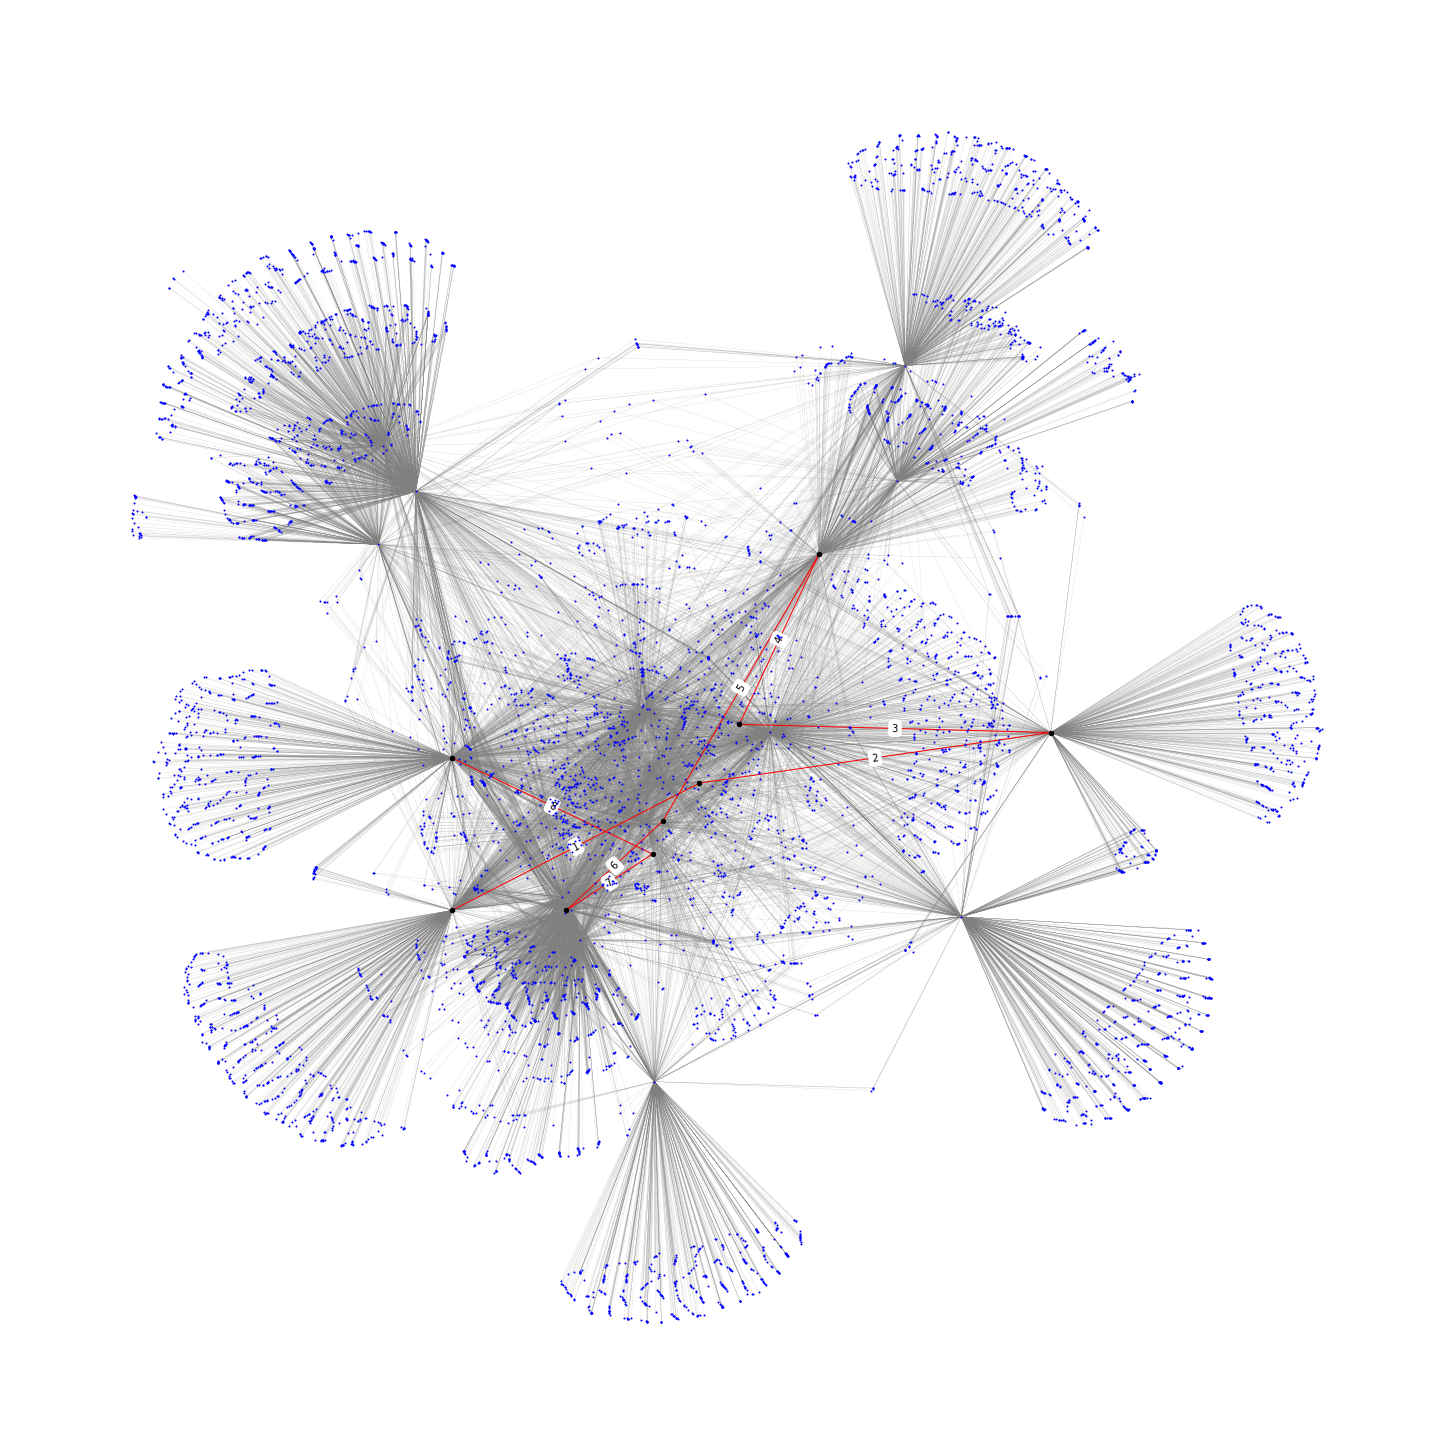

In [41]:
# I plot the graph and the path
plt.figure(figsize=(20,20))
pos = nx.spring_layout(H_hero_net2)
nx.draw(H_hero_net2, pos, with_labels=False, node_color='blue', edge_color='gray', node_size=1, width=0.1)
nx.draw_networkx_nodes(H_hero_net2, pos, nodelist=node_list, node_size=20, node_color='black')
nx.draw_networkx_edges(H_hero_net2, pos, edgelist=edge_list, width=1.0, edge_color='red')
nx.draw_networkx_edge_labels(H_hero_net2, pos, edge_labels=edge_labels)
plt.show()

## Visualization 4 - Visualize the disconnected graph

Here is the number of the links that should be disconnected

In [41]:
links = func4(G_hero_net1, 'CAPTAIN AMERICA', 'MR. FANTASTIC/REED R', n_heros, N=100)
print('The minimum number of links required to disconnect the original graph in two disconnected subgraphs is: {}'.format(links))

The minimum number of links required to disconnect the original graph in two disconnected subgraphs is: 99


In [43]:
H_hero_net1=G_hero_net1.subgraph(n_heros[:50])

Here is the plot the original graph

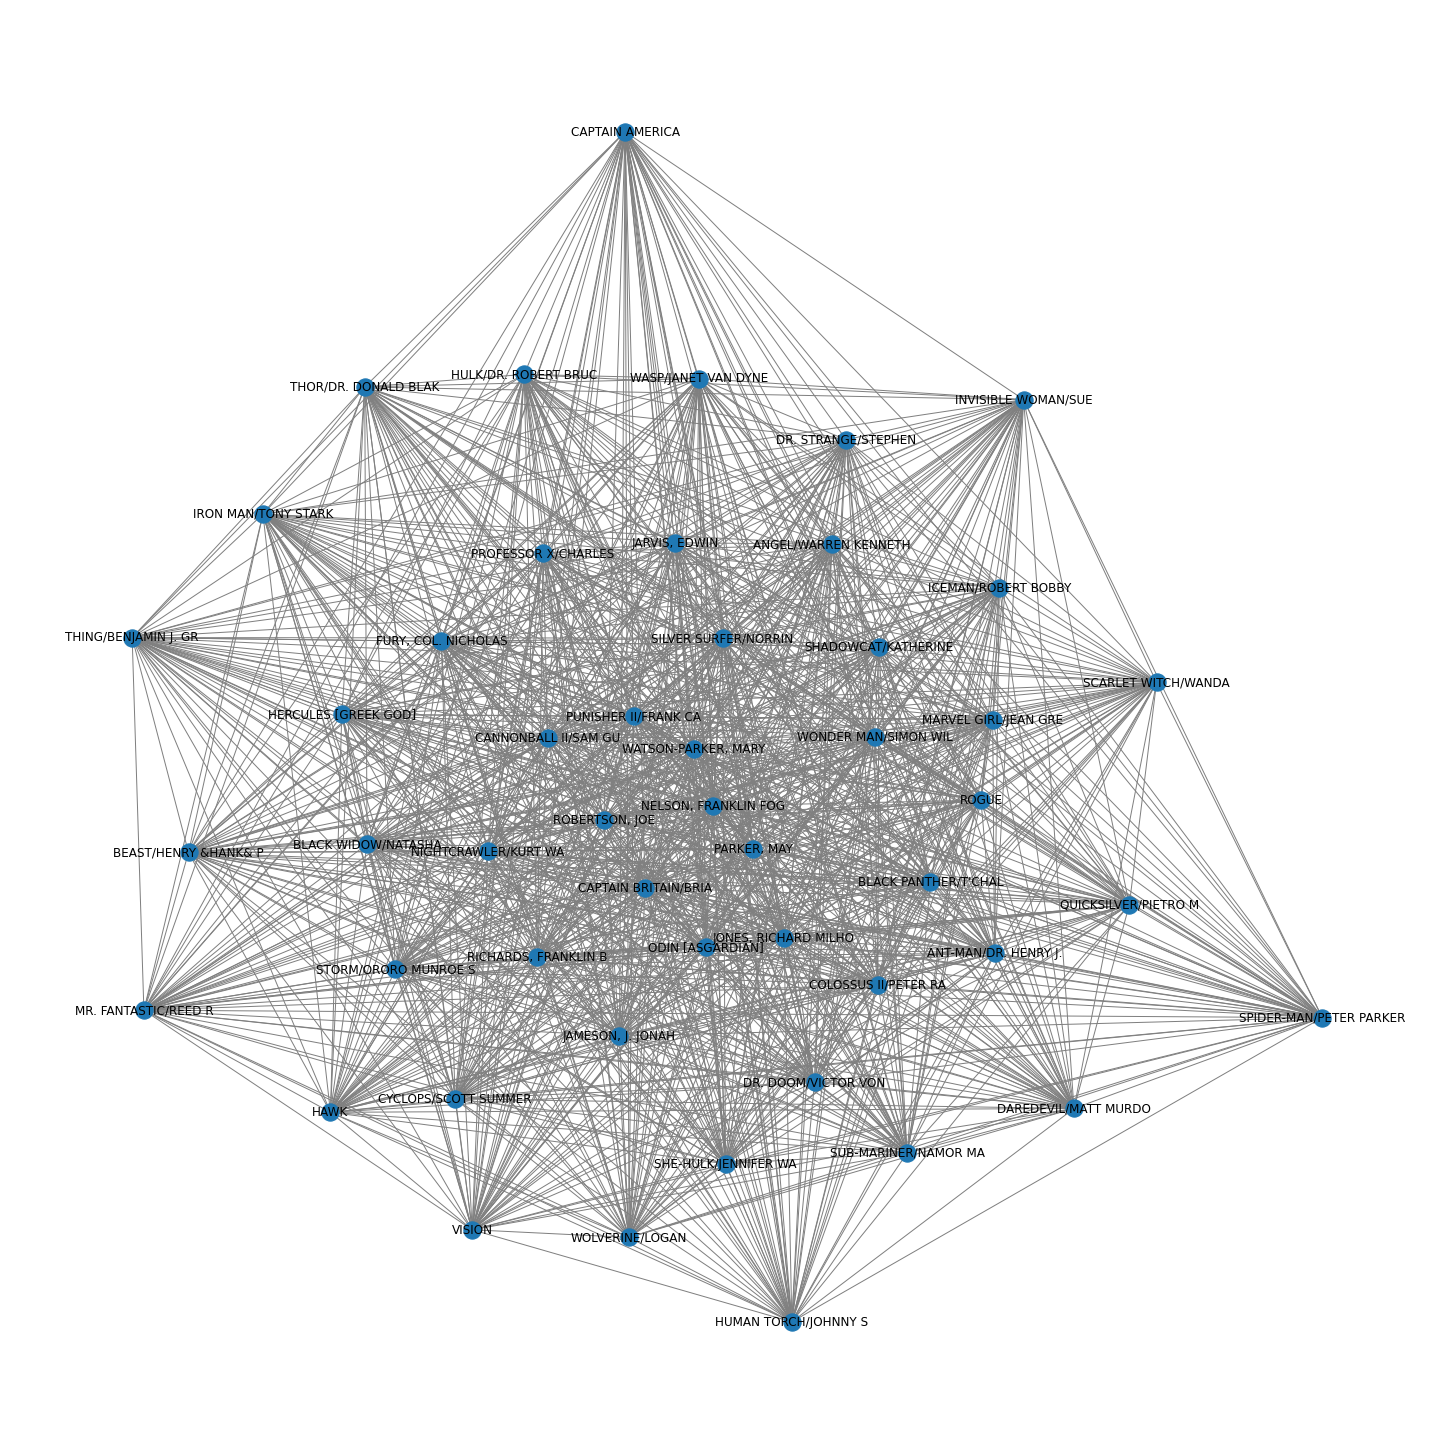

In [46]:
plt.figure(figsize=(20,20))
plt.clf()
nx.draw(H_hero_net1, with_labels=True, edge_color='gray')
plt.show()

# 6. Algorithmic Question

In [28]:
import numpy as np

In [29]:
#input
condition = False
while condition==False:
  
  path = str(input('Please enter the path code orientation: R L D U:\n')) #path string sequence
  if len(path)<=10:
    condition = True
  else:
    print('The string path should be less than 10, please try again:\n')

Please enter the path code orientation: R L D U:
DRU


In [30]:
def string_to_integer_list(path):
  l = len(path)
  int_arr = []
  for i in range(l):
    if path[i] =='U':
      int_arr.append(0)
    elif path[i] == 'D':
      int_arr.append(1)
    elif path[i] == 'L':
      int_arr.append(2) 
    elif path[i] == 'R':
      int_arr.append(3) 
  return int_arr

int_path = string_to_integer_list(path)
string_to_integer_list(path)

[1, 3, 0]

In [31]:
#finding all possible combination ex: RUR: RUR RRUR RRUUR RRUURR RUUR RUURR
def all_probablity(arr):
  l = len(arr)
  state = [arr]
  n = l
 
  go = False
  for i in range(l):
      m = []
      for k in range(n): 
        sub_state=[]
        for j in range(l):
          doubl = False
          for s in range(len(m)):
            if m[s]==j:
             
              go = True  
              break 
          if i == j:
            for _ in range(2):
              sub_state.append(arr[i])
          elif j<i:
             sub_state.append(arr[j])

          elif go==True:
            for _ in range(2):
              sub_state.append(arr[j])
              go = False
          else:
            sub_state.append(arr[j])
        m.append(k+1)
        state.append(sub_state)
      n = n -1
  return state 
print('All the way:')  
all_probablity(int_path)

All the way:


[[1, 3, 0],
 [1, 1, 3, 0],
 [1, 1, 3, 3, 0],
 [1, 1, 3, 3, 0, 0],
 [1, 3, 3, 0],
 [1, 3, 3, 0, 0],
 [1, 3, 0, 0]]

In [32]:
#path possible matrix 3*3
x = np.arange(1, 10).reshape(3, 3)
x

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [33]:
#>>>>>>>>>>>>>>>>>>>possible way<<<<<<<<<<<<<<<<<<<<<<<<<

def possible(x,s):     #possible finding way function
    position = []#up down left right; 0: not possible 1: possible. in this function the possible way recognized.
    a = False
    for i in range(3):
        if a == False:
            for j in range(3):
                if x[i][j]==s:
                    #up
                    if i == 0:
                        position.append(0)
                    else:
                        position.append(1)
                    #down   
                    if i ==2:
                        position.append(0)
                    else:
                        position.append(1)
                    #left   
                    if j == 0:
                        position.append(0)
                    else:
                        position.append(1)
                    #right  
                    if j == 2:
                        position.append(0)
                    else:
                        position.append(1)
                    a = True    
                    break

    return position

In [34]:
#>>>>>>>>>>>>>>>>>>Main Tree<<<<<<<<<<<<<<<<<<<<<<<<<<

def tree_possible_node(): #this function makes a tree of all possible way 
  tree = []
  s = 1
  for i in range(3):
    sub_tree = []
    for j in range(3):
      node = possible(x,s)
      s = s + 1
      sub_tree.append(node)
    tree.append(sub_tree) 
  return tree
print('  Tree structure:\n')  
tree = tree_possible_node()
tree  

  Tree structure:



[[[0, 1, 0, 1], [0, 1, 1, 1], [0, 1, 1, 0]],
 [[1, 1, 0, 1], [1, 1, 1, 1], [1, 1, 1, 0]],
 [[1, 0, 0, 1], [1, 0, 1, 1], [1, 0, 1, 0]]]

In [35]:
from re import L

#finding all  possible way with tree structure:

way = all_probablity(int_path)
l = len(way)

counter = 0
for s in range(l):
  lenght = len(way[s])
  
  for i in range(3):
    for j in range(3):
  
      y,z = i,j
      memory = []
      
      c = 0
      for n in range(lenght):
        con = True
      
        if tree[y][z][way[s][n]] == True:
          
          lm = len(memory)
          for m in range(lm):
            
            if memory[m]==x[y][z]:
             
              con = False
              break
          if  con == True:       
              if way[s][n]==0:
                  memory.append(x[y][z])
                #if possible(x,x[y][z])[0]  == True:
                  y,z=y-1,z
                  
                  c = c +1
              elif way[s][n]==1: 
                
                #if possible(x,x[y][z])[1]  == True:
                  memory.append(x[y][z])
                  y,z=y+1,z 
                 
                  
                  c = c +1
              elif way[s][n]==2: 
                #if possible(x,x[y][z])[2]  == True:
                  memory.append(x[y][z])
                  y,z=y,z-1 
                  
                  c = c +1
              elif way[s][n]==3: 
                
                #if possible(x,x[y][z])[3]  == True:
                  memory.append(x[y][z]) 
                  y,z=y,z+1 
                      
                  c = c +1 

          else: 
            con = False
            break  
          
      if con == True and c==lenght:
            counter = counter + 1
         
print(counter) 


13
